# Learning EEG Data Quality: A Random Forest Approach

<a id="0"></a> <br>
 # Table of Contents  
1. [Data Description](#1)<br>
2. [Import the necessary packages, libraries and methods](#2)   <br>  
3. [Load the Data](#3) <br>
    3.1 [Helper function to load the data](#4)<br>
    3.2 [Data Fusion](#5)<br>
4. [Classification Setup](#6) <br>
   4.1 [Splitting the dataset](#7) <br>
   4.2 [Random Forest Classification Model](#8)<br>
   4.3 [Method for the Confusion matrix, ROC-AUC and Accuracy score](#9)<br>
5. [Pipeline 1 (Clean vs Artifact then from Clean --> Healthy vs Pathological)](#10) <br>
   5.1 [Stage 1 (Clean vs Artifact)](#11) <br>
   5.2 [Stage 2 (Healthy vs Pathological)](#12) <br>
6. [Pipeline 2 (Normal vs Abnormal then from Abnormal --> Pathological vs Artifact) ](#13)<br>
   6.1 [Stage 1 (Normal vs Abnormal)](#14)<br>
   6.2 [Stage 2 (Pathological vs Artifact)](#15)<br>    
7. [ROC Curves for the two pipelines and their two stages](#16)   
   

<a id="1"></a> <br>
# 1. Data Description

The data for the investigation of this topic comes from Temple University’s TUH EEG corpus. The TUH EEG corpus is an enormous corpus created specifically to solve the problem of lack of good quality EEG data for scientific studies and research. Two subsets were selected from this large corpus, TUH Abnormal EEG Corpus (TUAB) and TUH Artifact EEG Corpus (TUAR) respectively. 

<a href = https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml#d_elec> Link to the Original EEG Corpus </a>


### Dataset at hand for this study
----
#### TUAB Dataset
* labels legend:
	1. label 0 = abnormal
	2. label 1 = normal
* Channel set: A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2, FZ, O1, O2, P3, P4, PZ, T3, T4, T5, T6  
* Sample frequency: 250 Hz


#### TUAR Dataset
* labels legend:
	1. label 0 = artifact
	2. label 1 = clean
* Channel set: A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2, FZ, O1, O2, P3, P4, PZ, T1, T2, T3, T4, T5, T6
* Sample frequency: 250 Hz

* Channels to be removed before merging: T1, T2

<a id="2"></a> <br>
# 2. Import the necessary packages, libraries and methods

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Feature Selection and Pre-processing Imports
from sklearn.preprocessing import StandardScaler

#Model Selection  and Classifier Imports
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

#Metrics Imports
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, RocCurveDisplay
from sklearn.metrics import balanced_accuracy_score, classification_report, roc_curve, auc, recall_score, f1_score, roc_auc_score

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import pairplot as pplot

#Data Augmentation Library
from imblearn.over_sampling import SMOTE

<a id = 3></a>
# 3. Load the data

### Making sense of Data

* Data - N-Dimensional numpy array with shape (200,500,23/21) , last dimension represents the no. of channels.
* Label - 200 labels for the samples
* ID - ID of the sample

<a id = 4></a>
## 3.1 Helper Function to load the data

* Load the datasets, plot a sample and check the shapes of the datasets

In [2]:
def read_from_h5(path):
    f = h5py.File(path, 'r')
    data = np.array(f['dataset'])
    label = np.array(f['label'])
    ID = np.array([i.decode('utf_8') for i in np.array(f['ID'])])
    
    return data, label, ID


data_ar, label_ar, ID_ar = read_from_h5('TUAR.hdf5')  # artifact(0) + clean(1) signal
data_ab, label_ab, ID_ab = read_from_h5('TUAB.hdf5')  # abnormal(0) + normal(1) signal


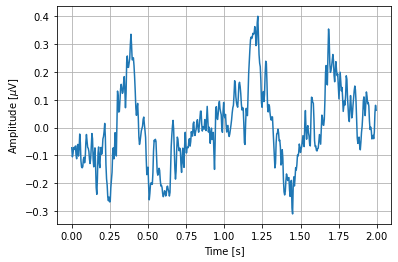

In [3]:
fig = plt.figure
time = np.arange(0,2,1/250)
plt.plot(time, data_ar[0,:,4])
plt.tight_layout
plt.ylabel('Amplitude [$\mu$V]')
# plt.title('Artifactual EEG - Channel 4 (fs=250Hz)')
plt.xlabel('Time [s]')
plt.grid(True)
plt.savefig('Artifactual_eeg_signal', dpi = 300)
plt.show()

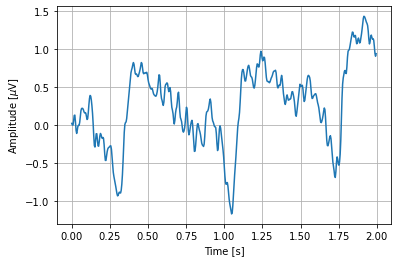

In [4]:
fig = plt.figure
time = np.arange(0,2,1/250)
plt.plot(time, data_ab[0,:,4])
plt.tight_layout
plt.ylabel('Amplitude [$\mu$V]')
# plt.title('Abnormal EEG - Channel 4 (fs=250Hz)')
plt.xlabel('Time [s]')
plt.grid(True)
plt.savefig('Abnormal_eeg_signal', dpi = 300)
plt.show()

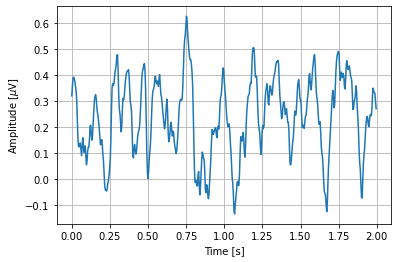

In [5]:
fig = plt.figure
time = np.arange(0,2,1/250)
plt.plot(time, data_ar[150,:,4])
plt.tight_layout
plt.ylabel('Amplitude [$\mu$V]')
# plt.title('Normal EEG - Channel 4 (fs=250Hz)')
plt.xlabel('Time [s]')
plt.grid(True)
plt.savefig('normal_eeg_signal', dpi = 300)
plt.show()


In [6]:
# Shape of the two datasets and Removing uncommon channels from TUAR dataset

print('Shape of the two datasets are TUAB: {} , TUAR: {}'.format(data_ab.shape , data_ar.shape))

data_ar = np.delete(data_ar,[17,18],axis = 2)
print('Shape of the two datasets are TUAB: {} , TUAR: {}'.format(data_ab.shape , data_ar.shape))

Shape of the two datasets are TUAB: (200, 500, 21) , TUAR: (200, 500, 23)
Shape of the two datasets are TUAB: (200, 500, 21) , TUAR: (200, 500, 21)


<a id=5></a>
## 3.2 Data Fusion
Combine the two datasets and the label vectors. <br>
### New class labels
---
* Class 1: Clean and Normal <br>
* Class 2: Abnormal <br>
* Class 3: Artifact <br>

In [7]:
def combineDatasets (dataset1, dataset2, newshape):
    d1 = dataset1.copy()
    d2 = dataset2.copy()
    
    data = np.vstack((d1,d2))
    print(data.shape)
    
    # For each sample/person combine the data from the 21 channels into a single vector
    data = data.reshape(newshape) 
    print(data.shape)
    
    return data

newshape = (400,500*21)
combinedData = combineDatasets(data_ab, data_ar, newshape)

(400, 500, 21)
(400, 10500)


In [8]:
# clean + normal  = 1, abnormal = 2, artifact = 3

def combineLabels(label_ab, label_ar):
    labeld1 = label_ab.copy() # abnormal + normal
    labeld2 = label_ar.copy() # artifact + clean
    
    labeld1[labeld1 == 0] = 2 # abnormal = 2
    labeld2[labeld2 == 0] = 3 # artifact = 3
    
    combinedLabels = np.concatenate((labeld1, labeld2))
    
    return combinedLabels

newLabels = combineLabels(label_ab,label_ar)


# permute the data
np.random.seed(12345)
idx = np.random.permutation(400)

combinedData = combinedData[idx]
newLabels = newLabels[idx]

# print(newLabels)

<a id=6></a>
# 4. Classification Setup

<a id=7></a>
## 4.1 Splitting the dataset

In [9]:
training_size = int(0.70 * (newLabels.size))

X_train = combinedData[: training_size]
y_train = newLabels[: training_size]

X_test = combinedData[training_size:]
y_test = newLabels[training_size:]

print(np.unique(y_train, return_counts=True))

(array([1, 2, 3]), array([145,  70,  65]))


<a id=8></a>
## 4.2 Random Forest Classifier Model

In [10]:
def rfmodel1(X_train, y_train, X_test, y_test):
#     clf = RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    
    clf.fit(X_train,y_train)
    
    training_prediction = clf.predict(X_train)
    test_prediction = clf.predict(X_test)
    
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    
    print('Training Score: ',train_score, '\nTest Score: ',test_score)
    
    return training_prediction, test_prediction, train_score, test_score


<a id=9></a>
## 4.3 Method for the confusion matrix, ROC-AUC and accuracy score

In [11]:
# Confusion Matrix of the predictions

def confusionMatrix(actual, predicted, title = "Predicted Results", labels = [False, True]):
    cm = metrics.confusion_matrix(actual,predicted)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix = cm,
        display_labels = labels,
    )
    cm_display = cm_display.plot(cmap=plt.cm.Reds,values_format='g')
    plt.grid(False)
#     plt.title(title)
    plt.savefig(title)
    plt.show()
    print ('Model ROC-AUC:',roc_auc_score(actual,predicted))
    print('Accuracy score :',accuracy_score(actual,predicted))
    print('Balanced Accuracy score :',balanced_accuracy_score(actual,predicted))


<a id=10></a>
# 5. Pipeline 1

Relabel the data in the training set for this stage into the classes:
  1. Clean (Clean + Normal + Abnormal) : Class 0
  2. Artifact : Class 1

In [12]:
# clean + normal  = 1, abnormal = 2, artifact = 3 -> Original relabeling
# (clean + normal + abnormal) 0  vs (Artifact) 1

X_train_pip1_stage1 = X_train.copy()
y_train_pip1_stage1 = y_train.copy()

y_train_pip1_stage1[(y_train_pip1_stage1 != 3)] = 0
y_train_pip1_stage1[y_train_pip1_stage1 == 3] = 1

X_test_pip1_stage1 = X_test.copy()
y_test_pip1_stage1 = y_test.copy()

y_test_pip1_stage1[(y_test_pip1_stage1 != 3)] = 0
y_test_pip1_stage1[y_test_pip1_stage1 == 3] = 1

print(np.unique(y_train_pip1_stage1,return_counts=True))

(array([0, 1]), array([215,  65]))


<a id=11></a>
## 5.1 Stage 1

In [13]:
p1s1train_prediction, p1s1test_prediction, p1s1train_score, p1s1test_score = rfmodel1(X_train_pip1_stage1, y_train_pip1_stage1, X_test_pip1_stage1, y_test_pip1_stage1)

Training Score:  1.0 
Test Score:  0.6916666666666667


### Confusion Matrix for stage 1 training data

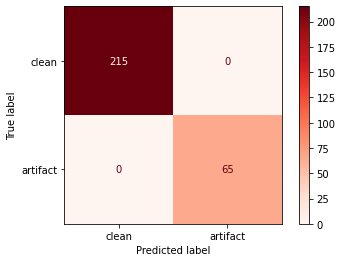

Model ROC-AUC: 1.0
Accuracy score : 1.0
Balanced Accuracy score : 1.0


In [14]:
confusionMatrix(y_train_pip1_stage1, p1s1train_prediction, 'p1s1_training', ['clean', 'artifact'])

### Confusion Matrix for the stage 1 test data

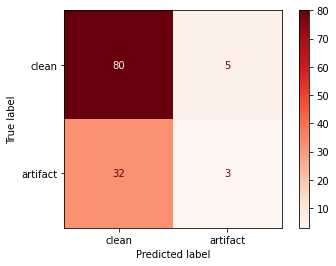

Model ROC-AUC: 0.5134453781512605
Accuracy score : 0.6916666666666667
Balanced Accuracy score : 0.5134453781512605


In [15]:
confusionMatrix(y_test_pip1_stage1, p1s1test_prediction, 'p1s1_test', ['clean', 'artifact'])

<a id=12></a>
## 5.2 Stage 2

Samples that were correctly classified as Class 0 (clean + normal + abnormal) are now selected.
These are relabeled further for the second stage of the pipeline.

* Class 0: Abnormal (Pathological)
* Class 1: Clean + Normal (Healthy)

In [16]:
# Pipeline 1 Stage 2
# (clean + normal + abnormal)  --> clean + normal (Healthy) 1 vs Abnormal (Pathological) 0


idx_train = np.where((p1s1train_prediction == y_train_pip1_stage1) & (y_train_pip1_stage1 == 0))[0]
idx_test = np.where(y_test != 3)[0]

X_train_pip1_stage2 = X_train[idx_train]
y_train_pip1_stage2 = y_train[idx_train]

# y_train_pip1_stage2[y_train_pip1_stage2 != 2] = 0 #Abnormal 
y_train_pip1_stage2[y_train_pip1_stage2 == 2] = 0 #Abnormal 

X_test_pip1_stage2 = X_test[idx_test]
y_test_pip1_stage2 = y_test[idx_test]

# y_test_pip1_stage2[y_test_pip1_stage2 != 2] = 0 #Abnormal 
y_test_pip1_stage2[y_test_pip1_stage2 == 2] = 0 #Abnormal 

np.unique(y_train_pip1_stage2, return_counts=True)

(array([0, 1]), array([ 70, 145]))

In [17]:
p1s2train_prediction, p1s2test_prediction, p1s2train_score, p1s2test_score = rfmodel1(X_train_pip1_stage2, y_train_pip1_stage2, X_test_pip1_stage2, y_test_pip1_stage2)


Training Score:  1.0 
Test Score:  0.7411764705882353


### Confusion Matrix for the stage 2 training data

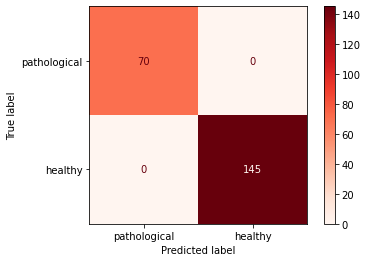

Model ROC-AUC: 1.0
Accuracy score : 1.0
Balanced Accuracy score : 1.0


In [18]:
confusionMatrix(y_train_pip1_stage2, p1s2train_prediction, 'p1s2_train', ['pathological', 'healthy'])

### Confusion Matrix for the stage 2 test data

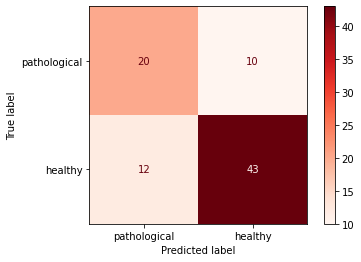

Model ROC-AUC: 0.7242424242424244
Accuracy score : 0.7411764705882353
Balanced Accuracy score : 0.7242424242424242


In [19]:
confusionMatrix(y_test_pip1_stage2, p1s2test_prediction, 'p1s2_test',['pathological', 'healthy'])

<a id=13></a>
# 6. Pipeline 2

In [20]:
# clean + normal  = 1, abnormal = 2, artifact = 3 -> Original relabeling

# (clean + normal --> Healthy) 1  vs (abnormal + Artifact ---> Abnormal) 0

X_train_pip2_stage1 = X_train.copy()
y_train_pip2_stage1 = y_train.copy()

y_train_pip2_stage1[(y_train_pip2_stage1 != 1)] = 0
# y_train_pip1_stage1[y_train_pip1_stage1 == 3] = 1

X_test_pip2_stage1 = X_test.copy()
y_test_pip2_stage1 = y_test.copy()

y_test_pip2_stage1[(y_test_pip2_stage1 != 1)] = 0
# y_test_pip1_stage1[y_test_pip1_stage1 == 3] = 1

print(np.unique(y_train_pip2_stage1,return_counts=True))

(array([0, 1]), array([135, 145]))


<a id=14></a>
## 6.1 Stage 1

In [21]:
p2s1train_prediction, p2s1test_prediction, p2s1train_score, p2s1test_score = rfmodel1(X_train_pip2_stage1, y_train_pip2_stage1, X_test_pip2_stage1, y_test_pip2_stage1)

Training Score:  1.0 
Test Score:  0.6


### Confusion Matrix for the stage 1 training data

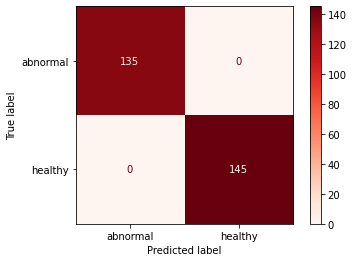

Model ROC-AUC: 1.0
Accuracy score : 1.0
Balanced Accuracy score : 1.0


In [22]:
confusionMatrix(y_train_pip2_stage1, p2s1train_prediction, 'p2s1_train', ['abnormal', 'healthy'])

### Confusion Matrix for the stage 1 test data

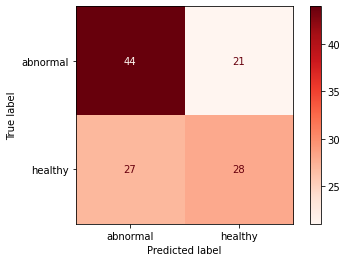

Model ROC-AUC: 0.593006993006993
Accuracy score : 0.6
Balanced Accuracy score : 0.593006993006993


In [23]:
confusionMatrix(y_test_pip2_stage1, p2s1test_prediction, 'p2s1_test', ['abnormal', 'healthy'])

<a id=15></a>
## 6.2 Stage 2

In [24]:
# Stage 2 --> (Pathological vs Artifact)

idx_train = np.where((p2s1train_prediction == y_train_pip2_stage1) & (y_train_pip2_stage1 == 0))[0]
idx_test = np.where(y_test != 1)[0]

X_train_pip2_stage2 = X_train[idx_train]
y_train_pip2_stage2 = y_train[idx_train]

y_train_pip2_stage2[y_train_pip2_stage2 != 2] = 1 #Artifact 
y_train_pip2_stage2[y_train_pip2_stage2 == 2] = 0 #Abnormal --> Pathological 

X_test_pip2_stage2 = X_test[idx_test]
y_test_pip2_stage2 = y_test[idx_test]

y_test_pip2_stage2[y_test_pip2_stage2 != 2] = 1 #Artifact
y_test_pip2_stage2[y_test_pip2_stage2 == 2] = 0 #Abnormal ---> Pathological

np.unique(y_train_pip2_stage2, return_counts=True)

(array([0, 1]), array([70, 65]))

In [25]:
p2s2train_prediction, p2s2test_prediction, p2s2train_score, p2s2test_score = rfmodel1(X_train_pip2_stage2, y_train_pip2_stage2, X_test_pip2_stage2, y_test_pip2_stage2)

Training Score:  1.0 
Test Score:  0.676923076923077


### Confusion Matrix for the stage 2 training data

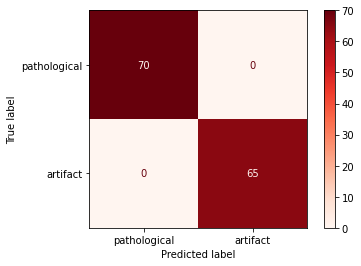

Model ROC-AUC: 1.0
Accuracy score : 1.0
Balanced Accuracy score : 1.0


In [26]:
confusionMatrix(y_train_pip2_stage2, p2s2train_prediction, 'p2s2_train', ['pathological', 'artifact'])

### Confusion Matrix for the stage 2 test data

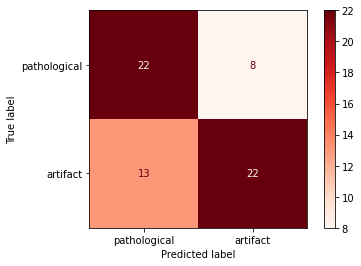

Model ROC-AUC: 0.680952380952381
Accuracy score : 0.676923076923077
Balanced Accuracy score : 0.680952380952381


In [27]:
confusionMatrix(y_test_pip2_stage2, p2s2test_prediction, 'p2s2_test', ['pathological', 'artifact'])

<a id=16></a>
# 7. ROC Curves for the two pipelines and their two stages

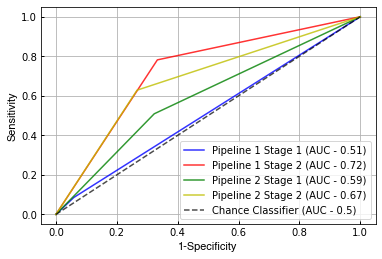

In [28]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test_pip1_stage1,p1s1test_prediction, ax = ax, color = 'b', alpha= 0.8)
RocCurveDisplay.from_predictions(y_test_pip1_stage2,p1s2test_prediction, ax = ax, color = 'r', alpha= 0.8)
RocCurveDisplay.from_predictions(y_test_pip2_stage1,p2s1test_prediction, ax = ax, color = 'g', alpha= 0.8)
RocCurveDisplay.from_predictions(y_test_pip2_stage2,p2s2test_prediction, ax = ax, color = 'y', alpha= 0.8)

# plt.title('ROC Curve for test data')
ax.plot([0,1], [0,1], 'k', linestyle="--", alpha = 0.7)
ax.set_xlabel('1-Specificity', fontdict={'size':11, 'family': 'helvetica'})
ax.set_ylabel('Sensitivity', fontdict={'size':11, 'family':'helvetica'})
ax.tick_params(direction='in',length=3, width=1, colors='k')
ax.grid(True)
ax.legend(['Pipeline 1 Stage 1 (AUC - 0.51)','Pipeline 1 Stage 2 (AUC - 0.72)','Pipeline 2 Stage 1 (AUC - 0.59)','Pipeline 2 Stage 2 (AUC - 0.67)','Chance Classifier (AUC - 0.5)'], loc='lower right')

plt.savefig('ROC curve')
plt.show()